### This code illustrates the fast AI implementation of the unsupervised "biological" learning algorithm from [Unsupervised Learning by Competing Hidden Units](https://doi.org/10.1073/pnas.1820458116) on MNIST data set. 
If you want to learn more about this work you can also check out this [lecture](https://www.youtube.com/watch?v=4lY-oAY0aQU) from MIT's [6.S191 course](http://introtodeeplearning.com/). 

This cell loads the data and normalizes it to the [0,1] range

In [23]:
import scipy.io
import numpy as np
import matplotlib.pyplot as plt
mat = scipy.io.loadmat('mnist_all.mat')

Nc=10    #вспомогательная переменная, зависящая от структуры mnist_all.mat
N=784    #image in MNIST is 28x28, so flat vector has 784 pixels

M=np.zeros((0,N)) #Здесь делают вектор нулей размера 0х784 (для конкатенации)
for i in range(Nc):
    M=np.concatenate((M, mat['train'+str(i)]), axis=0)#здесь выполняют конкатенацию (первая с пустым списком(нужной формы))
M=M/255.0 #every pixel of Grayscale image has values from 0 to 255. We normalize them to the [0, 1] range.

To draw a heatmap of the weights a helper function is created:

In [24]:
def draw_weights(synapses, Kx, Ky):
    yy=0
    HM=np.zeros((28*Ky,28*Kx)) #
    for y in range(Ky):
        for x in range(Kx):
            HM[y*28:(y+1)*28,x*28:(x+1)*28]=synapses[yy,:].reshape(28,28) #reshape(28,28)
            yy += 1
    plt.clf()
    nc=np.amax(np.absolute(HM))
    im=plt.imshow(HM,cmap='bwr',vmin=-nc,vmax=nc)
    fig.colorbar(im,ticks=[np.amin(HM), 0, np.amax(HM)])
    plt.axis('off')
    fig.canvas.draw()

`eps0` - initial learning rate that is linearly annealed during training; 

`hid` - number of hidden units that are displayed as an `Ky` by `Kx` array by the helper function defined above; 

`mu` - the mean of the gaussian distribution that initializes the weights; 

`sigma` - the standard deviation of that gaussian; 

`Nep` - number of epochs; `Num` - size of the minibatch; 

`prec` - parameter that controls numerical precision of the weight updates; 

`delta` - the strength of the anti-hebbian learning; 

`p` - Lebesgue norm of the weights; 

`k` - ranking parameter. 

In [25]:
eps0=2e-2    # learning rate
Ns=60000
Kx=10
Ky=10
hid=Kx*Ky    # number of hidden units that are displayed in Ky by Kx array
mu=0.0
sigma=1.0
Nep=20      # number of epochs
Num=20      # size of the minibatch
prec=1e-30
delta=0.4    # Strength of the anti-hebbian learning
p=3          # Lebesgue norm of the weights
k=2          # ranking parameter, must be integer that is bigger or equal than 2 (влияет на anti-hebian learning посредством h*)

This cell defines the main code. The external loop runs over epochs `nep`, the internal loop runs over minibatches. For every minibatch the overlap with the data `tot_input` is calculated for each data point and each hidden unit. The sorted strengths of the activations are stored in `y`. The variable `yl` stores the activations of the post synaptic cells - it is denoted by g(Q) in Eq 3 of [Unsupervised Learning by Competing Hidden Units](https://doi.org/10.1073/pnas.1820458116), see also Eq 9 and Eq 10. The variable `ds` is the right hand side of Eq 3. The weights are updated after each minibatch in a way so that the largest update is equal to the learning rate `eps` at that epoch. The weights are displayed by the helper function after each epoch. 

<IPython.core.display.Javascript object>


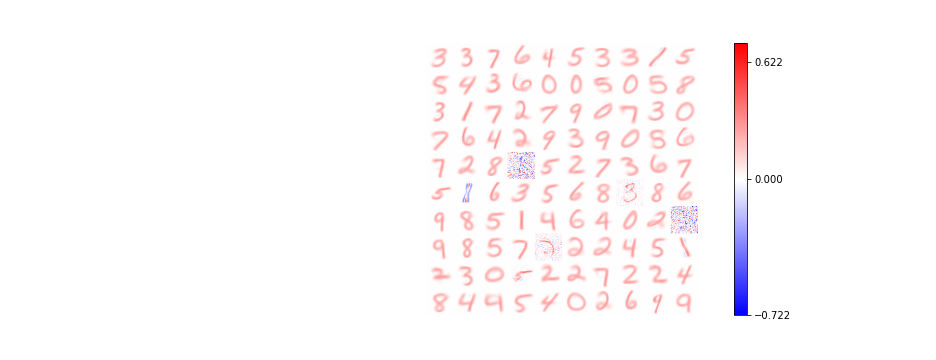

In [26]:
%matplotlib inline
%matplotlib notebook
fig=plt.figure(figsize=(13,5))


synapses = np.random.normal(mu, sigma, (hid, N))

for nep in range(Nep):
    eps=eps0*(1-nep/Nep) #FIXME
    
    M=M[np.random.permutation(Ns),:] #shuffle pictures from dataset (shuffle rows actually. но т.к. картинка сплющена в строку, строка это и есть вся картинка)
    for i in range(Ns//Num): #going through minibatches
        inputs=np.transpose(M[i*Num:(i+1)*Num,:]) #shape (728, minibatch_size)
        
        sig=np.sign(synapses) #привел синапсы к +-1
        tot_input=np.dot(sig*np.absolute(synapses)**(p-1),inputs)
        y=np.argsort(tot_input,axis=0) #h* depends on the power of newrons. 
                                       #Other words h* depends on (k, sorted tot_input)
    
        
        yl=np.zeros((hid,Num))
        yl[y[hid-1,:],np.arange(Num)]=1.0
        yl[y[hid-k],np.arange(Num)]=-delta #Anti-hebbian learning process depends on h*
        
        xx=np.sum(np.multiply(yl,tot_input),1) # 1 в конце <=> axis=1 (по опр np.sum)
        ds=np.dot(yl,np.transpose(inputs)) - np.multiply(np.tile(xx.reshape(xx.shape[0],1),(1,N)),synapses)

        nc=np.amax(np.absolute(ds))
        if nc<prec:
            nc=prec
        synapses += eps*np.true_divide(ds,nc)

    draw_weights(synapses, Kx, Ky)

After the neurons are trained, we will perform the classification (overlay) with their help

In [27]:
_labels = np.array([3,3,7,6,4,5,3,3,1,5,5,4,3,6,0,0,5,0,5,8,3,1,7,2,7,9,0,7,3,0,7,6,4,2,9,3,9,0,5,6,7,2,8,None,5,2,7,3,6,7,5,1,6,3,5,6,8,3,8,6,9,8,5,1,4,6,4,0,2,None,9,8,5,8,2,2,2,4,5,1,2,3,0,5,2,2,7,2,2,4,8,4,9,5,4,0,2,6,4,9])
def classifier(n, train_data):
    """
    Classifies digit by image
    """
    classific = np.zeros(n)
    for i in range(n):
        classific[i] = np.sum(np.multiply(synapses[i],train_data))
    return _labels[np.argmax(classific)]

classifier(16, M[2])

3

Calculating the score:

In [28]:
test_data = np.zeros((0,N))

rights = 0
count = 0
for i in range(3,Nc):
    for j in range(mat['test{}'.format(i)].shape[0]):
        if classifier(100, mat['test{}'.format(i)][j])==i:
            rights+=1
        count+=1
print(f'Accuracy: {rights/count*100}%', f'({rights}/{count})')

Accuracy: 85.29111338100103% (5845/6853)


Using only **100 labels**, we got a classification with an accuracy of 85% for the MNIST dataset.